In [277]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_poisson_deviance
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import partial_dependence

In [278]:
#Import data
data = pd.read_csv('/Users/cr24/Desktop/Data Science Assignment/Assignment.csv')

# transform the column names to lowercase
data.columns = data.columns.str.lower()
data = data.rename(columns= {'duree': 'expo','nbrtotan': 'freq','nbrtotc': 'nclaims'})
data = data.drop(['lnexpo','codposs','chargtot','sexp','split'],axis=1)


In [279]:
data.head(100)

,ageph,expo,nclaims,freq,agecar,fuelc,usec,fleetc,sportc,coverp,powerc
0,64,1.000000,0,0.000000,2-5,Petrol,Private,No,No,MTPL+,66-110
1,28,0.046575,1,21.470588,6-10,Petrol,Private,No,No,MTPL,66-110
2,58,0.402740,0,0.000000,>10,Petrol,Private,No,No,MTPL,<66
3,37,0.169863,0,0.000000,2-5,Petrol,Professional,No,No,MTPL+++,66-110
4,29,1.000000,0,0.000000,6-10,Petrol,Private,No,No,MTPL+,<66
...,...,...,...,...,...,...,...,...,...,...,...
95,49,1.000000,0,0.000000,6-10,Petrol,Private,No,No,MTPL+,<66
96,28,1.000000,0,0.000000,2-5,Petrol,Private,Yes,No,MTPL+++,66-110
97,29,1.000000,0,0.000000,6-10,Petrol,Private,No,No,MTPL,66-110
98,31,0.301370,2,6.636364,>10,Petrol,Private,No,No,MTPL,66-110


In [280]:
# List of categorical variables
categorical_variables = ['agecar', 'fuelc', 'usec', 'fleetc', 'sportc', 'coverp', 'powerc']

# Encoding categorical variables one by one
pd.options.mode.copy_on_write = True
label_encoders = {}
for var in categorical_variables:
    label_encoders[var] = LabelEncoder()
    data[var] = label_encoders[var].fit_transform(x[var])

In [281]:
data.head(100)

,ageph,expo,nclaims,freq,agecar,fuelc,usec,fleetc,sportc,coverp,powerc
0,64,1.000000,0,0.000000,1,1,0,0,0,1,0
1,28,0.046575,1,21.470588,2,1,0,0,0,0,0
2,58,0.402740,0,0.000000,3,1,0,0,0,0,1
3,37,0.169863,0,0.000000,1,1,1,0,0,2,0
4,29,1.000000,0,0.000000,2,1,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...
95,49,1.000000,0,0.000000,2,1,0,0,0,1,1
96,28,1.000000,0,0.000000,1,1,0,1,0,2,0
97,29,1.000000,0,0.000000,2,1,0,0,0,0,0
98,31,0.301370,2,6.636364,3,1,0,0,0,0,0


In [282]:
data.dtypes

ageph        int64
expo       float64
nclaims      int64
freq       float64
agecar       int64
fuelc        int64
usec         int64
fleetc       int64
sportc       int64
coverp       int64
powerc       int64
dtype: object

In [283]:
# Features
columns_all = ['expo','ageph','agecar','fuelc','usec','fleetc','sportc','coverp','powerc']
x = data[columns_all]

# Frequency
y = np.array(data['freq'])



In [284]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [285]:
columns = ['ageph','agecar','fuelc','usec','fleetc','sportc','coverp','powerc']
expo_train = X_train['expo']
X_train = X_train[columns]
expo_test = X_test['expo']
X_test = X_test[columns]


In [286]:
# initialize a tree of depth 2
tree_freq = DecisionTreeRegressor(criterion='poisson', min_samples_split=100, min_samples_leaf=1000)
# fit the tree to our target with weights
tree_freq.fit(X=X_train, y=y_train, sample_weight=expo_train)
# print the tree
tree_freq

DecisionTreeRegressor(criterion='poisson', min_samples_leaf=1000,
                      min_samples_split=100)

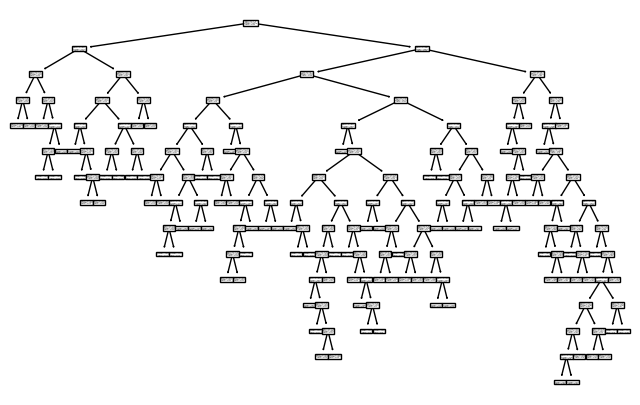

In [287]:
# plot the tree structure
plt.figure(figsize=(8, 5), dpi=100)
plot_tree(tree_freq, feature_names=columns);

In [288]:
y_pred = tree_freq.predict(X_train)
MSE_train = mean_squared_error(y_train,y_pred, sample_weight=expo_train)
print('MSE for training data:', MSE_train)

y_pred_test = tree_freq.predict(X_test)
MSE_test = mean_squared_error(y_test,y_pred_test, sample_weight=expo_test)
print('MSE for test data:', MSE_test)

MSE for training data: 0.19047413968768118
MSE for test data: 0.19287575207106014


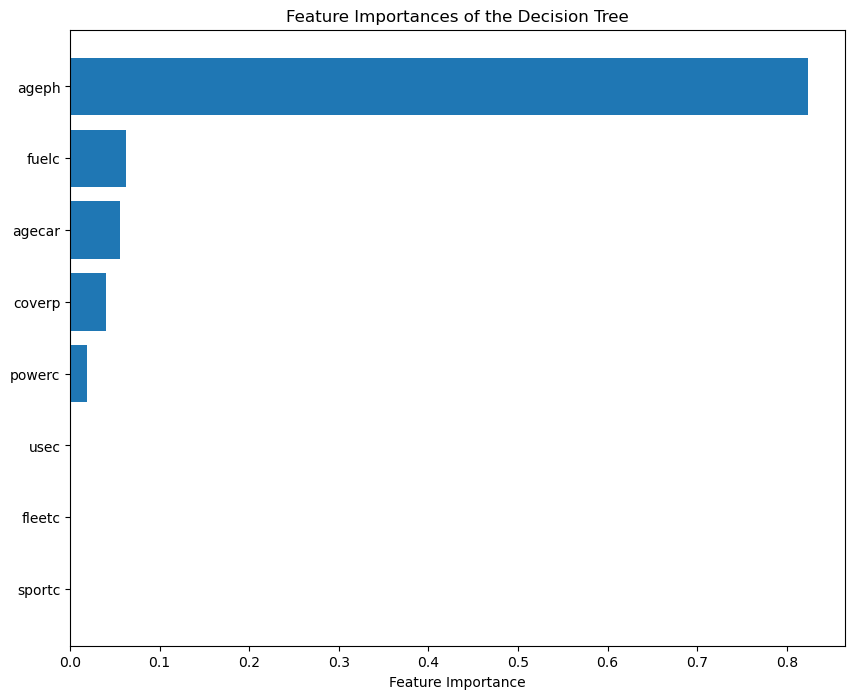

In [289]:
feature_importances = pd.Series(tree_freq.feature_importances_, index=X_train.columns)

# Sort the feature importances in descending order
sorted_feature_importances = feature_importances.sort_values(ascending=False)

# Create the horizontal bar plot
plt.figure(figsize=(10, 8))
plt.barh(sorted_feature_importances.index, sorted_feature_importances.values)
plt.xlabel('Feature Importance')
plt.title('Feature Importances of the Decision Tree')
plt.gca().invert_yaxis()  # To display the highest importance at the top
plt.show()

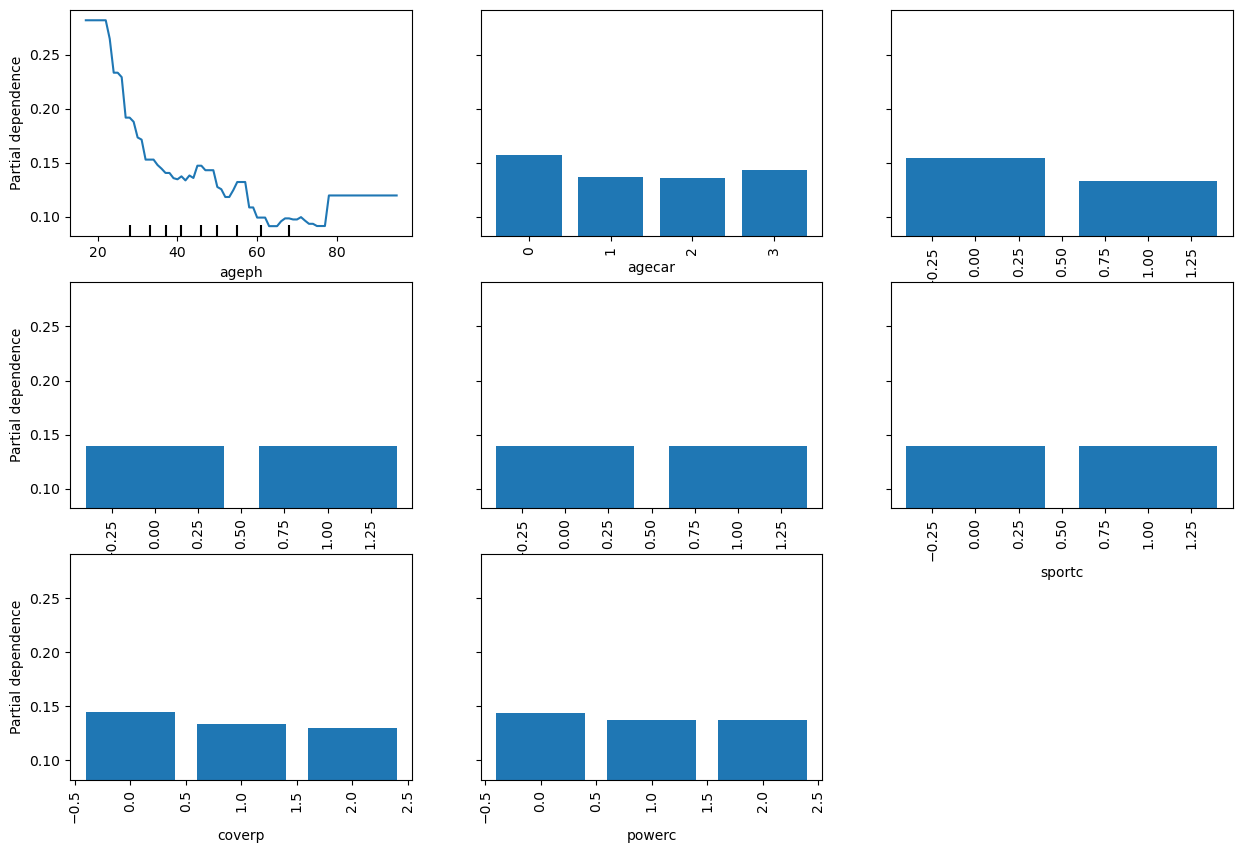

In [290]:
# create pdps for a couple of features
fig, ax = plt.subplots(figsize=(15, 10))
cat
PartialDependenceDisplay.from_estimator(tree_freq, X_train, features = columns, categorical_features=categorical_variables, kind='average', ax=ax);

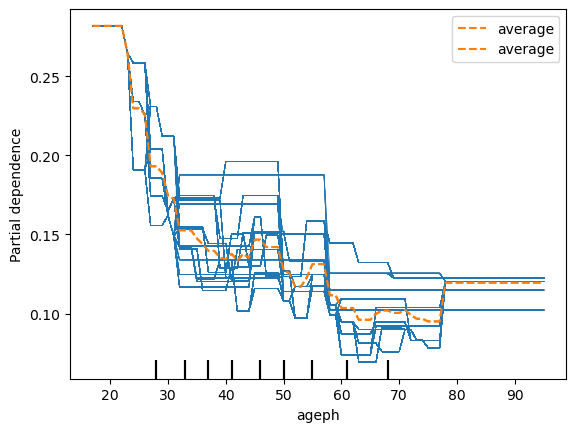

In [317]:
# Compute partial dependence plots and individual conditional expectation
ice = ['powerc']
display = PartialDependenceDisplay.from_estimator(tree_freq, X_train, features=ice, kind='both')
display.plot(ax=display.axes_)


In [323]:
# get data from different age groups
age_0_25 = X_train[(X_train['ageph'] > 0) & (X_train['ageph'] <= 25)]
age_25_50 = X_train[(X_train['ageph'] > 25) & (X_train['ageph'] <= 50)]
age_50_75 = X_train[(X_train['ageph'] > 50) & (X_train['ageph'] <= 75)]
age_75_100 = X_train[(X_train['ageph'] > 75) & (X_train['ageph'] <= 100)]


,ageph,agecar,fuelc,usec,fleetc,sportc,coverp,powerc
12355,23,3,1,0,0,0,0,1
28201,25,3,1,0,0,0,0,1
29337,24,3,1,0,0,0,0,1
65989,22,0,1,0,0,0,2,1
120152,23,2,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...
26105,25,1,0,0,0,0,0,1
123684,23,1,1,0,0,1,0,0
9268,24,1,0,0,0,0,0,1
19457,25,1,1,0,0,0,2,1


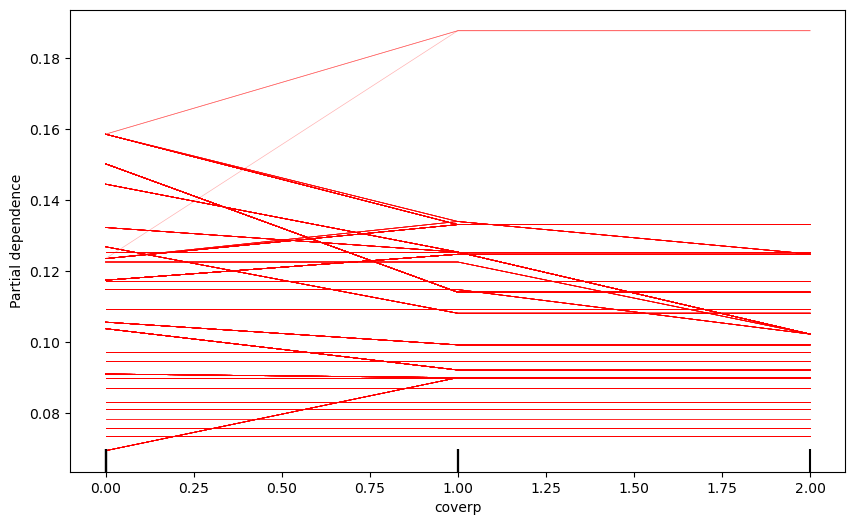

In [365]:
# Compute partial dependence plots and individual conditional expectation
ice = ['coverp']

# Create a larger figure
fig, ax = plt.subplots(figsize=(10, 6))

# First plot
display_1 = PartialDependenceDisplay.from_estimator(tree_freq, age_50_75, features=ice, kind='individual', line_kw={"color": 'red'}, ax=ax,grid_resolution=500)


